# Read KNMI observations using hydropandas

This notebook introduces how to use the `hydropandas` package to read, process and visualise KNMI data.

## <a id=top></a>Notebook contents

1. [KnmiObs](#KnmiObs)
2. [Get KNMI data](#reading)
3. [Get ObsCollections](#readingOC)

In [17]:
from hydropandas import ObsCollection
from hydropandas.io import io_knmi
from hydropandas.observation import PrecipitationObs, EvaporationObs, MeteoObs
from IPython.display import display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import logging

In [18]:
logging.basicConfig(level=logging.INFO)

## Observation types<a id=KNMIObs></a>

The hydropandas package has a function to read all kinds of KNMI observations. These are stored in an `Obs` object. There are three types of observations you can obtain from the KNMI:
- `EvaporationObs`, for evaporation time series
- `PrecipitationObs`, for precipitation time series
- `MeteoObs`, for all the other meteorological time series

With the code below we get the Evaporation in [m/day] for KNMI station 344 (Rotterdam Airport).

INFO:hydropandas.io.io_knmi:download knmi EV24 data from station 344-ROTTERDAM between 2020-01-01 00:00:00 and 2021-10-13 17:16:12.927305
INFO:hydropandas.io.io_knmi:station 344 has 0 missing measurements


,EV24
2020-01-01 01:00:00,0.0004
2020-01-02 01:00:00,0.0001
2020-01-03 01:00:00,0.0001
2020-01-04 01:00:00,0.0001
2020-01-05 01:00:00,0.0003


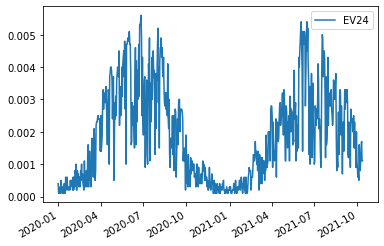

In [42]:
o = EvaporationObs.from_knmi(344)
display(o.head())
o.plot();

INFO:hydropandas.io.io_knmi:last RD measurement available at the Bilt is from 2021-09-20
INFO:hydropandas.io.io_knmi:assuming no measurements are available at other stations before this date
INFO:hydropandas.io.io_knmi:changing end_date to 2021-09-20
INFO:hydropandas.io.io_knmi:download knmi RH data from station 344-ROTTERDAM between 2020-01-01 00:00:00 and 2021-09-20 09:00:00
INFO:hydropandas.io.io_knmi:transform RH, Etmaalsom van de neerslag (in 0.1 mm) (0 voor <0.05mm) / Daily precipitation amount (in 0.1 mm) (0 for <0.05mm) lower than 0.05 mm to 0 mm
INFO:hydropandas.io.io_knmi:station 344 has 0 missing measurements


,RH
2020-01-01 01:00:00,0.0000
2020-01-02 01:00:00,0.0000
2020-01-03 01:00:00,0.0000
2020-01-04 01:00:00,0.0027
2020-01-05 01:00:00,0.0001


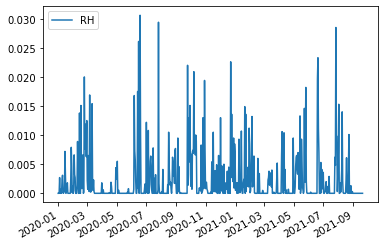

In [43]:
o = PrecipitationObs.from_knmi(344)
display(o.head())
o.plot();

**attributes**

A `MeteoObs` object has the following attributes:

* `name`: station name and variable
* `x`: x-coördinate in m RD
* `y`: y-coördinate in m RD
* `station`: station number
* `meta`: dictionary with other metadata

In [44]:
print(f"name: {o.name}")
print(f"x,y: {(o.x, o.y)}")
print(f"station: {o.station}")
print("metadata:")
for key, item in o.meta.items():
    print(f'    {key}: {item}')

name: RH_ROTTERDAM
x,y: (90598.0, 442813.0)
station: 344
metadata:
    LON_east: {'344': 4.447}
    LAT_north: {'344': 51.962}
    ALT_m: {'344': -4.3}
    NAME: {'344': 'Rotterdam'}
    RH: Etmaalsom van de neerslag (in m) (0 voor <0.05mm) / Daily precipitation amount (in m) (0 for <0.05mm)
    x: 90598.0
    y: 442813.0
    station: 344
    name: RH_ROTTERDAM
    variable: RH


## Get KNMI data<a id=reading></a>

There are 2 main method to obtain meteorological data:

1. `from_knmi`
2. `from_nearest_xy`

Below you can see how they can be called to obtain the precipitation data. Notice that they return the same data because station 344 is nearest to the given xy coördinates.

In [45]:
o1 = PrecipitationObs.from_knmi(344)
o2 = PrecipitationObs.from_nearest_xy(90600, 442800)
o1.equals(o2)

INFO:hydropandas.io.io_knmi:last RD measurement available at the Bilt is from 2021-09-20
INFO:hydropandas.io.io_knmi:assuming no measurements are available at other stations before this date
INFO:hydropandas.io.io_knmi:changing end_date to 2021-09-20
INFO:hydropandas.io.io_knmi:download knmi RH data from station 344-ROTTERDAM between 2020-01-01 00:00:00 and 2021-09-20 09:00:00
INFO:hydropandas.io.io_knmi:transform RH, Etmaalsom van de neerslag (in 0.1 mm) (0 voor <0.05mm) / Daily precipitation amount (in 0.1 mm) (0 for <0.05mm) lower than 0.05 mm to 0 mm
INFO:hydropandas.io.io_knmi:station 344 has 0 missing measurements
INFO:hydropandas.io.io_knmi:last RD measurement available at the Bilt is from 2021-09-20
INFO:hydropandas.io.io_knmi:assuming no measurements are available at other stations before this date
INFO:hydropandas.io.io_knmi:changing end_date to 2021-09-20
INFO:hydropandas.io.io_knmi:download knmi RH data from station 344-ROTTERDAM between 2020-01-01 00:00:00 and 2021-09-20 0

True

**read options**

The `MeteoObs.from_knmi` method contains the following keyword arguments:

- `stn`: station number.
- `startdate`: the start date of the time series you want, default is 1st of January 2019.
- `enddate`: the end date of the time series you want, default is today.
- `fill_missing_obs`: option to fill missing values with values from the nearest KNMI station. If measurements are filled an extra column is added to the time series in which the station number is shown that was used to fill a particular missing value.
- `interval`: time interval of the time series, default is 'daily'
- `raise_exception`: option to raise an error when the requested time series is empty.
***

The 3 examples below give a brief summary of these options

INFO:hydropandas.io.io_knmi:download knmi TG data from station 344-ROTTERDAM between 1960-01-01 00:00:00 and 2021-10-13 17:16:15.157408
INFO:hydropandas.io.io_knmi:station 344 has 2 missing measurements
INFO:hydropandas.io.io_knmi:trying to fill 2 measurements with station [210]
INFO:hydropandas.io.io_knmi:download knmi TG data from station 210-VALKENBURG between 1960-01-01 00:00:00 and 2021-10-13 17:16:15.157408


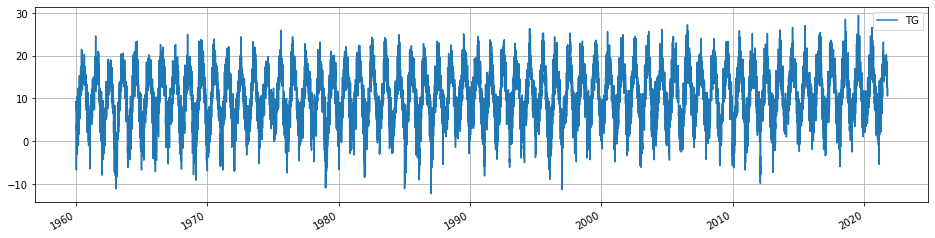

In [46]:
#example 1 get daily average temperature from 1900 till now
o_t = MeteoObs.from_knmi(344, 'TG', startdate='1960')
o_t.plot(figsize=(16,4), grid=True);

INFO:hydropandas.io.io_knmi:download knmi RH data from station 892-GIERSBERGEN between 1972-01-01 00:00:00 and 2021-10-13 17:16:16.931979
INFO:hydropandas.io.io_knmi:last RD measurement available at the Bilt is from 2021-09-20
INFO:hydropandas.io.io_knmi:assuming no measurements are available at other stations before this date
INFO:hydropandas.io.io_knmi:changing end_date to 2021-09-20
INFO:hydropandas.io.io_knmi:download knmi RH data from station 892-GIERSBERGEN between 1972-01-01 00:00:00 and 2021-09-20 09:00:00
INFO:hydropandas.io.io_knmi:station 1892 has no measurements before 1993-11-01 09:00:00
INFO:hydropandas.io.io_knmi:station 1892 has 7975 missing measurements
INFO:hydropandas.io.io_knmi:trying to fill 7975 measurements with station [1910]
INFO:hydropandas.io.io_knmi:download knmi RH data from station 910-AMMERZODEN between 1972-01-01 00:00:00 and 2021-09-20 09:00:00


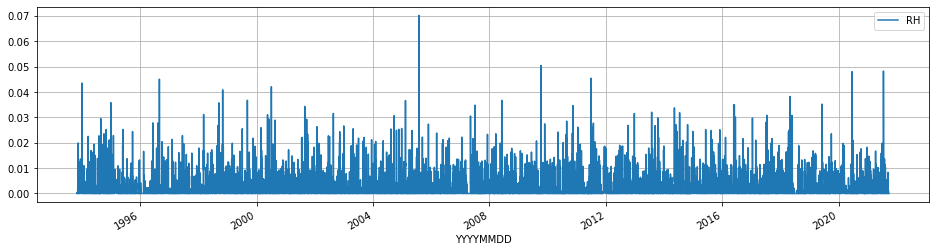

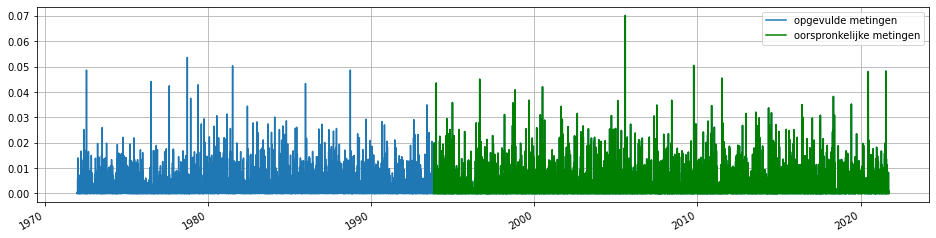

In [47]:
#example 2 get daily average precipitation from 1972 with and without filling missing measurements
o_rd = PrecipitationObs.from_knmi(1892, startdate='1972', fill_missing_obs=False)
o_rd.plot(figsize=(16,4), grid=True)

o_rd_filled = PrecipitationObs.from_knmi(1892, startdate='1972', fill_missing_obs=True)
fig, ax = plt.subplots()
o_rd_filled['RH'].plot(figsize=(16,4), ax=ax, label='opgevulde metingen');
o_rd_filled.loc[o_rd_filled['station_opvulwaarde'].isna(),'RH'].plot(color='green',ax=ax,grid=True,  label='oorspronkelijke metingen');
ax.legend()

In [48]:
#see the station_opvulwaarde
display(o_rd.head())
display(o_rd_filled.head())

,RH
YYYYMMDD,
1993-11-01 09:00:00,0.0000
1993-11-02 09:00:00,0.0000
1993-11-03 09:00:00,0.0005
1993-11-04 09:00:00,0.0000
1993-11-05 09:00:00,0.0000


,RH,station_opvulwaarde
1972-01-01 09:00:00,0.0000,1910
1972-01-02 09:00:00,0.0000,1910
1972-01-03 09:00:00,0.0000,1910
1972-01-04 09:00:00,0.0000,1910
1972-01-05 09:00:00,0.0004,1910


In [49]:
# example 3 get evaporation and print additional information during download using the logging module
logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.INFO)

o_ev = EvaporationObs.from_knmi(344, startdate='1972', fill_missing_obs=True)
o_ev

INFO:hydropandas.io.io_knmi:download knmi EV24 data from station 344-ROTTERDAM between 1972-01-01 00:00:00 and 2021-10-13 17:16:19.055604
INFO:hydropandas.io.io_knmi:station 344 has no measurements before 1987-09-12 01:00:00
INFO:hydropandas.io.io_knmi:station 344 has 5809 missing measurements
INFO:hydropandas.io.io_knmi:trying to fill 5809 measurements with station [210]
INFO:hydropandas.io.io_knmi:download knmi EV24 data from station 210-VALKENBURG between 1972-01-01 00:00:00 and 2021-10-13 17:16:19.055604
INFO:hydropandas.io.io_knmi:trying to fill 5563 measurements with station [330]
INFO:hydropandas.io.io_knmi:download knmi EV24 data from station 330-HOEK-VAN-HOLLAND between 1972-01-01 00:00:00 and 2021-10-13 17:16:19.055604
INFO:hydropandas.io.io_knmi:trying to fill 5563 measurements with station [348]
INFO:hydropandas.io.io_knmi:download knmi EV24 data from station 348-CABAUW between 1972-01-01 00:00:00 and 2021-10-13 17:16:19.055604
INFO:hydropandas.io.io_knmi:trying to fill 549

,EV24,station_opvulwaarde
1972-01-01 01:00:00,0.0002,260
1972-01-02 01:00:00,0.0002,260
1972-01-03 01:00:00,0.0002,260
1972-01-04 01:00:00,0.0000,260
1972-01-05 01:00:00,0.0000,260
...,...,...
2021-10-08 01:00:00,0.0011,NaN
2021-10-09 01:00:00,0.0015,NaN
2021-10-10 01:00:00,0.0017,NaN
2021-10-11 01:00:00,0.0011,NaN


## Get ObsCollections<a id=readingOC></a>

It is also possible to read multiple `KnmiObs` objects at once and store them in an `ObsCollection` object. For this we use the `ObsCollection.from_knmi()` method. Below an example to obtain precipitation (RH) and evaporation (EV24) from the KNMI station of Rotterdam and De Bilt. 

In [50]:
oc = ObsCollection.from_knmi(stns=[344, 260], meteo_vars=['RH', 'EV24'], ObsClass=[PrecipitationObs, EvaporationObs])
oc

INFO:hydropandas.io.io_knmi:last RD measurement available at the Bilt is from 2021-09-20
INFO:hydropandas.io.io_knmi:assuming no measurements are available at other stations before this date
INFO:hydropandas.io.io_knmi:changing end_date to 2021-09-20
INFO:hydropandas.io.io_knmi:download knmi RH data from station 344-ROTTERDAM between 2020-01-01 00:00:00 and 2021-09-20 09:00:00
INFO:hydropandas.io.io_knmi:transform RH, Etmaalsom van de neerslag (in 0.1 mm) (0 voor <0.05mm) / Daily precipitation amount (in 0.1 mm) (0 for <0.05mm) lower than 0.05 mm to 0 mm
INFO:hydropandas.io.io_knmi:station 344 has 0 missing measurements
INFO:hydropandas.io.io_knmi:last RD measurement available at the Bilt is from 2021-09-20
INFO:hydropandas.io.io_knmi:assuming no measurements are available at other stations before this date
INFO:hydropandas.io.io_knmi:changing end_date to 2021-09-20
INFO:hydropandas.io.io_knmi:download knmi RH data from station 260-DE-BILT between 2020-01-01 00:00:00 and 2021-09-20 09:

,x,y,filename,station,meteo_var,obs
name,,,,,,
RH_ROTTERDAM,90598.000000,442813.000000,,344,RH,-----metadata------ name : RH_ROTTERDAM x : 9...
RH_DE-BILT,141002.996557,456772.017696,,260,RH,-----metadata------ name : RH_DE-BILT x : 141...
EV24_ROTTERDAM,90598.000000,442813.000000,,344,EV24,-----metadata------ name : EV24_ROTTERDAM x :...
EV24_DE-BILT,141002.996557,456772.017696,,260,EV24,-----metadata------ name : EV24_DE-BILT x : 1...


Besides giving a list of stations it is also possible to:
- specify `locations` as a dataframe with x, y coördinates (RD_new), the function will find the nearest KNMI station for every location.
- specify `xmid` and `ymid` which are 2 arrays corresponding to a structured grid to obtain the nearest KNMI station for every cell in the grid.

In [51]:
ObsCollection.from_knmi(locations=pd.DataFrame(index=['Rotterdam'], data ={'x':77500, 'y':399500}), 
                        meteo_vars=['RH'], ObsClass=[PrecipitationObs])

INFO:hydropandas.io.io_knmi:last RD measurement available at the Bilt is from 2021-09-20
INFO:hydropandas.io.io_knmi:assuming no measurements are available at other stations before this date
INFO:hydropandas.io.io_knmi:changing end_date to 2021-09-20
INFO:hydropandas.io.io_knmi:download knmi RH data from station 837-STEENBERGEN-NB between 2020-01-01 00:00:00 and 2021-09-20 09:00:00
INFO:hydropandas.io.io_knmi:station 1837 has 0 missing measurements


,x,y,filename,station,meteo_var,obs
name,,,,,,
RH_STEENBERGEN-NB,80782.746045,399822.730277,,1837,RH,-----metadata------ name : RH_STEENBERGEN-NB ...


In [52]:
ObsCollection.from_knmi(xmid=np.array([77500]), ymid=np.array([399500]), 
                        meteo_vars=['RH'], ObsClass=[PrecipitationObs])

INFO:hydropandas.io.io_knmi:last RD measurement available at the Bilt is from 2021-09-20
INFO:hydropandas.io.io_knmi:assuming no measurements are available at other stations before this date
INFO:hydropandas.io.io_knmi:changing end_date to 2021-09-20
INFO:hydropandas.io.io_knmi:download knmi RH data from station 837-STEENBERGEN-NB between 2020-01-01 00:00:00 and 2021-09-20 09:00:00
INFO:hydropandas.io.io_knmi:station 1837 has 0 missing measurements


,x,y,filename,station,meteo_var,obs
name,,,,,,
RH_STEENBERGEN-NB,80782.746045,399822.730277,,1837,RH,-----metadata------ name : RH_STEENBERGEN-NB ...
